<a href="https://colab.research.google.com/github/wesslen/llm-evaluations/blob/main/notebooks/01_llm_evaluations_reference_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
%%capture
# use uv for virtual environment https://docs.astral.sh/uv/
!uv pip install --system bert-score rouge-score sacrebleu evaluate transformers moverscore pytorch-pretrained-bert pyemd unbabel-comet mauve-text

> ⚠ This notebook uses a GPU (T4, which is free on Colab). If you run on Colab, be sure to set by Connect > Change Runtime type. For running on more examples, you may want to use more powerful GPUs like A100 or H100s.

## Reference-based Generative Metrics

<img src="https://arxiv.org/html/2408.09169v1/extracted/5797240/figures/metric_families_usage_across_venues-2.png" alt="Automatic Metrics in Natural Language Generation:
A Survey of Current Evaluation Practices" width="300"/>

[Automatic Metrics in Natural Language Generation:
A Survey of Current Evaluation Practices](https://arxiv.org/abs/2408.09169v1), Schmidtová et al., 2024

The paper includes a detailed metric taxonomy (see [Appendix](#Appendix)).

Let's start with the most popular: Overlap-based metrics like BLEU, ROUGE, and METEOR.

For a great overview of BLEU vs ROUGE, see [Clément Brutti-Mairesse's blog post on them](https://clementbm.github.io/theory/2021/12/23/rouge-bleu-scores.html) (figures below).

| Category | Family | Example Metrics |
|----------|---------|-----------------|
| Overlap | BLEU | • BLEU-1/2/3/4<br>• SacreBLEU<br>• Self-BLEU |
| | ROUGE | • ROUGE-1/2/L<br>• ROUGE-F1 |
| | Other Overlap | • METEOR<br>• CIDEr<br>• PARENT |


## Overlap

### ROUGE

Initially made for summary evaluations (**R**ecall-**O**riented **U**nderstudy for **G**isting **E**valuation).

ROUGE scores are based on F1-score of n-gram overlap.

![](https://clementbm.github.io/assets/2021-12-23/rouge-unigrams.png)

In [2]:
%%time
from rouge_score import rouge_scorer

# Sample texts for evaluation
reference = "The way to make people trustworthy is to trust them"
candidate = "To make people trustworthy, you need to trust them"

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(candidate, reference)

print("ROUGE Score Results:")
print(f"ROUGE-1: {scores['rouge1'].fmeasure:.3f}")
print(f"ROUGE-2: {scores['rouge2'].fmeasure:.3f}")
print(f"ROUGE-L: {scores['rougeL'].fmeasure:.3f}")
print("\n")

ROUGE Score Results:
ROUGE-1: 0.737
ROUGE-2: 0.588
ROUGE-L: 0.737


CPU times: user 1.42 s, sys: 205 ms, total: 1.63 s
Wall time: 2.37 s


> Unigram matches tend to measure adequacy while longer n-grams matches account for fluency.

### BLEU


BLEU (Bilingual Evaluation Understudy): is used for **machine translation**. In fact, [Reiter 2018](https://direct.mit.edu/coli/article/44/3/393/1598/A-Structured-Review-of-the-Validity-of-BLEU) found

> Overall, the evidence supports using BLEU for diagnostic evaluation of MT systems (which is what it was originally proposed for), but **does not support using BLEU outside of MT**, for evaluation of individual texts, or for scientific hypothesis
testing.

BLEU measures the precision of token overlap through n-grams between a reference (e.g., gold standard) and a model's prediction (i.e., candidate or system).

In [3]:
# input / source -- what should be translated
source_texts = [
    "Hello, my dog is cute",
    "The weather is nice today",
    "I love programming"
]

# hypothetical model predictions
candidates = [
    "Salut, mon chien est mignon",
    "Le temps est beau aujourd'hui",
    "J'adore la programmation"
]

# gold standard (references)
references = [
    [
      "Bonjour, mon chien est mignon",
      "Le temps est beau aujourd'hui",
      "J'aime la programmation"
    ]
]

`sacrebleu` provides a standardized way to calculate BLEU. SacreBLEU expects references as a list of lists (multiple references per translation) ([see docs](https://github.com/mjpost/sacrebleu/tree/master#using-sacrebleu-from-python)).

In [4]:
%%time
from sacrebleu.metrics import BLEU

bleu = BLEU()
bleu_result = bleu.corpus_score(candidates, references)

print("BLEU Score Results:")
print(f"BLEU Score: {bleu_result.score:.3f}")
print(f"Counts: {bleu_result.counts}")
print(f"Totals: {bleu_result.totals}")
print(f"Precisions: {[f'{p:.1f}' for p in bleu_result.precisions]}")
print(f"Brevity Penalty: {bleu_result.bp:.3f}")
print("\n")

BLEU Score Results:
BLEU Score: 80.540
Counts: [12, 9, 6, 4]
Totals: [14, 11, 8, 5]
Precisions: ['85.7', '81.8', '75.0', '80.0']
Brevity Penalty: 1.000


CPU times: user 29.1 ms, sys: 6.09 ms, total: 35.2 ms
Wall time: 41.8 ms


## BLEU Score Calculation

### 1. N-gram Matches
* Count matching n-grams (1 to 4) between candidate and references
* Example for 1st sentence unigrams:
```
Candidate: "Salut(1), mon(1), chien(1), est(1), mignon(1)"
Reference: "Bonjour, mon(1), chien(1), est(1), mignon(1)"
```
→ 4/5 matches

### 2. Precision Calculation

Counts/Totals for each n-gram:

* Unigrams: 12/14 = 85.7%
* Bigrams: 9/11 = 81.8%
* Trigrams: 6/8 = 75.0%
* 4-grams: 4/5 = 80.0%

### 3. Final BLEU

* Geometric mean of precisions: `exp(0.25 * sum(log(p)))`
* Brevity Penalty = 1.0 (candidates not shorter than references)
* BLEU = `BP * exp(0.25 * sum(log(p))) = 80.540`

The differences in scores come from words like "Salut" vs "Bonjour" and "J'adore" vs "J'aime".

In [5]:
bleu_result

BLEU = 80.54 85.7/81.8/75.0/80.0 (BP = 1.000 ratio = 1.000 hyp_len = 14 ref_len = 14)

In [6]:
# provides how calculated
bleu.get_signature()

nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.3

<img src="https://arxiv.org/html/2408.09169v1/extracted/5797240/figures/BLEU_and_ROUGE_variants.png" alt="BLEU and ROUGE variant counts across INLG and ACL papers" width="600"/>

In 2023 major NLP and NLG conferences (INLG and ACL papers), the  majority of papers used BLEU or ROUGE-L.

### METEOR

METEOR, is a machine translation evaluation metric  based on a generalized concept of unigram matching between the machine-produced translation and human-produced reference translations.

METEOR evaluates text using unigram matching (exact, stemmed, synonym with WordNet) and computes an F-score, including a penalty for fragmented matches.

![](https://img1.wsimg.com/isteam/ip/683a65a0-e168-404b-b9c7-0971d8289f02/METEOR.png/:/cr=t:0%25,l:0%25,w:100%25,h:100%25/rs=w:1280)

In [7]:
import nltk
from nltk.translate import meteor_score
from nltk.translate.meteor_score import meteor_score as meteor
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)

# Example showing METEOR's handling of synonyms
references = ["The cat is sitting on the mat."]
candidates = [
    "The cat is sitting on the mat.",  # Exact match
    "The feline is sitting on the mat.",  # Synonym
    "The cat is resting on the mat.",  # Synonym
    "A dog is sitting on the mat."  # Different meaning
]

# convert to a function
def meteor_score_single(reference, candidate):
    ref_tokens = word_tokenize(reference)
    cand_tokens = word_tokenize(candidate)
    return meteor_score.single_meteor_score(ref_tokens, cand_tokens)

print("\nSynonym Handling Example:")
print(f"Reference: {references[0]}")
print("\nCandidate Scores:")
for candidate in candidates:
    score = meteor_score_single(references[0], candidate)
    print(f"'{candidate}': {score:.3f}")


Synonym Handling Example:
Reference: The cat is sitting on the mat.

Candidate Scores:
'The cat is sitting on the mat.': 0.999


Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

'The feline is sitting on the mat.': 0.865
'The cat is resting on the mat.': 0.865
'A dog is sitting on the mat.': 0.748


## Similarity-based

| Category | Family | Example Metrics |
|----------|---------|-----------------|
| Semantic Similarity | BERTScore | • BERTScore (F1/Precision/Recall) |
| | BARTScore | • BARTScore (faithfulness/precision/recall) |
| | Other Similarity | • Cosine Similarity<br>• SimCSE<br>• Sentence-BERT |


### Bert Score

Embedding-based evaluates token overlaps using BERT embeddings.

![](https://miro.medium.com/v2/resize:fit:700/1*i9IAfRP48Po4JpQTbNfr0g.png)

In [8]:
# input / source -- Same example from earlier
source_texts = [
    "Hello, my dog is cute",
    "The weather is nice today",
    "I love programming"
]

# hypothetical model predictions
candidates = [
    "Salut, mon chien est mignon",
    "Le temps est beau aujourd'hui",
    "J'adore la programmation"
]

# gold standard (references)
references = [
    [
      "Bonjour, mon chien est mignon",
      "Le temps est beau aujourd'hui",
      "J'aime la programmation"
    ]
]

# uses a different reference format
refs2 = [list(ref) for ref in zip(*references)]

print(refs2)

[['Bonjour, mon chien est mignon'], ["Le temps est beau aujourd'hui"], ["J'aime la programmation"]]


In [9]:
%%time
import contextlib
import warnings

# ignore warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

from bert_score import score

P, R, F1 = score(candidates, refs2, lang='en', verbose=True)

print("BERT Score Results:")
print(f"Precision: {P.mean().item():.3f}")
print(f"Recall: {R.mean().item():.3f}")
print(f"F1: {F1.mean().item():.3f}")
print("\n")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.90 seconds, 3.33 sentences/sec
BERT Score Results:
Precision: 0.972
Recall: 0.963
F1: 0.967


CPU times: user 9.23 s, sys: 1.42 s, total: 10.7 s
Wall time: 16.9 s


### MoverScore

![](https://img1.wsimg.com/isteam/ip/683a65a0-e168-404b-b9c7-0971d8289f02/MoverScore.png)

In [10]:
%%time

candidates = [
    "Salut, mon chien est mignon",
    "Le temps est beau aujourd'hui",
    "J'adore la programmation"
]

# gold standard (references)
references = [
      "Bonjour, mon chien est mignon",
      "Le temps est beau aujourd'hui",
      "J'aime la programmation"
]

# requires GPU
from moverscore import word_mover_score  # MoverScore
from collections import defaultdict

# Sample texts for evaluation
# Uses Word Mover Distance with contextual embeddings
# Higher scores indicate better similarity
idf_dict_hyp = defaultdict(lambda: 1.)
idf_dict_ref = defaultdict(lambda: 1.)

mover_scores = word_mover_score(
    references, candidates,
    idf_dict_ref, idf_dict_hyp,
    stop_words=[], n_gram=1,
    remove_subwords=True
)

print("MoverScore Results:")
for i, score in enumerate(mover_scores):
    print(f"Text pair {i+1}: {score:.3f}")
print("\n")

/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/modeling.py:603: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_loca

MoverScore Results:
Text pair 1: 0.851
Text pair 2: 1.000
Text pair 3: 0.792


CPU times: user 2.44 s, sys: 623 ms, total: 3.06 s
Wall time: 4.92 s


### BART Score

> BARTScore is a text-generation evaluation metric that treats model evaluation as a text-generation task 🔄
>
> Other metrics approach the evaluation problem from different ML task perspectives; for instance, ROUGE and BLUE formulate it as an unsupervised matching task, BLUERT and COMET as a supervised regression, and BEER as a supervised ranking task.
>
> Meanwhile, BARTScore formulates it as a text-generation task. Its idea is to leverage BART's pre-trained contextual embeddings to return a score that measures either the faithfulness, precision, recall, or F-score response of the main text-generation model.
>
> For example, if we want to measure faithfulness, the way it works is that we would take the source and the generated text from our model and use BART to calculate the log token probability of the generated text given the source; we can then weight those results and return the sum.

[Insight from HF comment by Santiago Viquez](https://huggingface.co/posts/santiviquez/809039256258115)

In [11]:
%%time
# Uses BART model for scoring
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)

CPU times: user 1.99 s, sys: 1.44 s, total: 3.43 s
Wall time: 11.2 s


In [12]:
%%time

candidates = [
    ["Salut, mon chien est mignon"],
    ["Le temps est beau aujourd'hui"],
    ["J'adore la programmation"]
]

def compute_bartscore(source, target):
    # Tokenize
    batch = bart_tokenizer(source, target, return_tensors="pt", padding=True, truncation=False)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    # Generate score
    with torch.no_grad():
        outputs = bart_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=input_ids
        )

    return -outputs.loss.item()  # Negative log likelihood

bart_scores = [
    compute_bartscore(ref, cand)
    for ref, cand in zip(refs2, candidates)
]

print("BARTScore Results:")
for i, score in enumerate(bart_scores):
    print(f"Text pair {i+1}: {score:.3f}")
print("\n")

BARTScore Results:
Text pair 1: -1.173
Text pair 2: -0.817
Text pair 3: -1.270


CPU times: user 75.2 ms, sys: 91 µs, total: 75.3 ms
Wall time: 96.8 ms


Since BARTScore users the average log-likelihood for target tokens, the calculated scores will be smaller than 0 (the probability is between 0 and 1, so the log of it should be negative). The higher the log-likelihood, the higher the probability.

To give an example, if SummaryA gets a score of -1 while SummaryB gets a score of -100, this means that the model thinks SummaryA is better than summaryB.

## Text Classifiers

| Category | Family | Example Metrics |
|----------|---------|-----------------|
| Text Classifiers | Quality Estimation | • COMET-QE<br>• CTRLEval<br>• USR |
| | Style Classifiers | • Sentiment Accuracy<br>• Toxicity<br>• Grammaticality |
| | Unieval | • coherence<br>• consistency<br>• fluency |

### COMET

[COMET](https://unbabel.github.io/COMET/html/index.html) newer translation metric aided by different models (see [Guerreiro et al. 2023](https://huggingface.co/papers/2310.10482)).

**Default model**: `Unbabel/wmt22-comet-da` - This model uses a reference-based regression approach and is built on top of XLM-R. It provides scores ranging from 0 to 1, where 1 represents a perfect translation.

**Upcoming model**: `Unbabel/wmt22-cometkiwi-da` - This **reference-free** model uses a regression approach and is built on top of InfoXLM. Like the default model, it also provides scores ranging from 0 to 1.

> # ⚠ Warning
> I found `comet` package `2.2.2` had an issue using `module 'comet' has no attribute 'load_from_checkpoint'` when trying to use. Be sure to always check OS libraries for recent updates and support. Since this looks like it hasn't been updated since March 2024, you should generally avoid to prevent problems down the road.

## Perplexity

| Category | Family | Example Metrics |
|----------|---------|-----------------|
| Perplexity | MAUVE | • MAUVE with different LMs |
| | Perplexity | • Bits per character<br>• Model PPL<br>• GPT-PPL |

### Perplexity

For a great explanation of perplexity, [watch this video](https://www.youtube.com/watch?v=KCXDr-UOb9A&t=138s) by Sasha Rush.

In [13]:
%%time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

CPU times: user 262 ms, sys: 279 ms, total: 541 ms
Wall time: 2.8 s


In [14]:
%%time

# Prepare text
text = "This is a sample text to evaluate perplexity."
encodings = tokenizer(text, return_tensors='pt')

# Calculate perplexity
with torch.no_grad():
    outputs = model(encodings.input_ids, labels=encodings.input_ids)
    ppl = torch.exp(outputs.loss)

print("Perplexity Results:")
print(f"Perplexity: {ppl.item():.3f}")

Perplexity Results:
Perplexity: 125.153
CPU times: user 144 ms, sys: 1.82 ms, total: 146 ms
Wall time: 154 ms


### MAUVE

MAUVE is obtained by computing Kullback–Leibler (KL) divergences between the two distributions in a quantized embedding space of a foundation model.

See [these docs](https://krishnap25.github.io/mauve/) including [these tips](https://krishnap25.github.io/mauve/#best-practices-for-mauve). While it has its own standalone, for this I recommend using Huggingface's `evaluations` package.

## Huggingface `evaluations`

There are different aspects of a typical machine learning pipeline that can be evaluated and for each aspect. `evaluate` provides a tool:

1. Metric: A metric is used to evaluate a model’s performance and usually involves the model’s predictions as well as some ground truth labels. You can find all integrated metrics at [evaluate-metric](https://huggingface.co/evaluate-metric).
2. Comparison: A comparison is used to compare two models. This can for example be done by comparing their predictions to ground truth labels and computing their agreement. You can find all integrated comparisons at [evaluate-comparison](https://huggingface.co/evaluate-comparison).
3. Measurement: The dataset is as important as the model trained on it. With measurements one can investigate a dataset’s properties. You can find all integrated measurements at [evaluate-measurement](https://huggingface.co/evaluate-measurement).

Includes metric cards for all metrics like:

<img src="https://huggingface.co/datasets/evaluate/media/resolve/main/metric-widget.png" alt="Metric " width="300"/>



### MAUVE

In [15]:
# fix candidates format
candidates = [
    "Salut, mon chien est mignon",
    "Le temps est beau aujourd'hui",
    "J'adore la programmation"
]

print(f"References: {references}")
print(f"\nCandidates: {candidates}")

References: ['Bonjour, mon chien est mignon', "Le temps est beau aujourd'hui", "J'aime la programmation"]

Candidates: ['Salut, mon chien est mignon', "Le temps est beau aujourd'hui", "J'adore la programmation"]


In [16]:
%%time

# HF evaluate calculation
from evaluate import load

hf_mauve = load("mauve")

results = hf_mauve.compute(predictions=candidates, references=references)
print(f"MAUVE score: {results.mauve}")

Loading tokenizer
Tokenizing text...
Loading tokenizer
Loading model
Featurizing tokens


Featurizing p:   0%|          | 0/3 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/3 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 1
kmeans time: 0.06 s
total discretization time: 0.13 seconds
MAUVE score: 1.0000000000000002
CPU times: user 5.17 s, sys: 2.81 s, total: 7.98 s
Wall time: 23.8 s


### SacreBLEU

In [17]:
%%time

hf_bleu = load("sacrebleu")
results = hf_bleu.compute(predictions=candidates, references=references)
print(results)

{'score': 80.54036088451565, 'counts': [12, 9, 6, 4], 'totals': [14, 11, 8, 5], 'precisions': [85.71428571428571, 81.81818181818181, 75.0, 80.0], 'bp': 1.0, 'sys_len': 14, 'ref_len': 14}
CPU times: user 49.2 ms, sys: 2.81 ms, total: 52.1 ms
Wall time: 541 ms


### Multiple metrics and Radar Plot

Candidates / predictions:
['Salut, mon chien est mignon', "Le temps est beau aujourd'hui", "J'adore la programmation"]
References / gold standard:
['Bonjour, mon chien est mignon', "Le temps est beau aujourd'hui", "J'aime la programmation"]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Metric Scores:
BLEU: 0.8054
ROUGE-1: 0.8500
ROUGE-2: 0.6944
ROUGE-L: 0.8500
METEOR: 0.8170
BERTScore: 0.9675


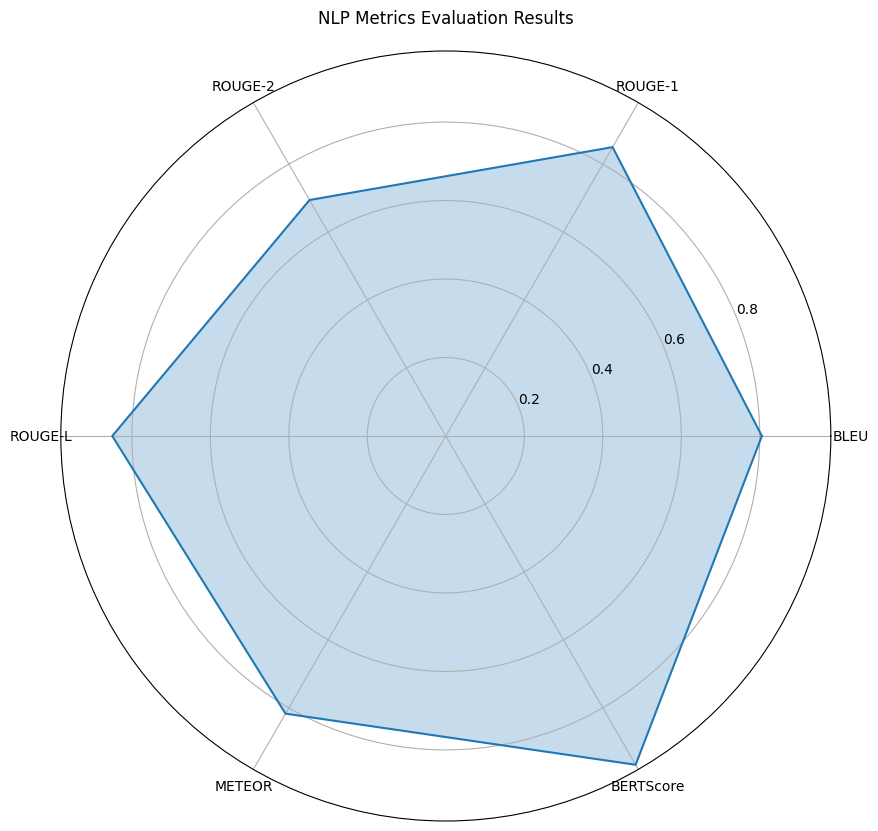

CPU times: user 1.33 s, sys: 342 ms, total: 1.67 s
Wall time: 5.11 s


In [18]:
%%time

import evaluate
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(predictions, references):
    """
    Calculate multiple NLP evaluation metrics using Hugging Face evaluate.

    Args:
        predictions (list): List of predicted texts
        references (list): List of reference texts

    Returns:
        dict: Dictionary containing all metric scores
    """
    # Initialize metrics
    bleu = evaluate.load('sacrebleu')
    rouge = evaluate.load('rouge')
    meteor = evaluate.load('meteor')
    bert_score = evaluate.load('bertscore')

    # Calculate scores
    results = {}

    # BLEU score
    bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
    results['BLEU'] = bleu_score['score'] / 100  # Normalize to 0-1 scale

    # ROUGE scores
    rouge_scores = rouge.compute(predictions=predictions, references=references)
    results['ROUGE-1'] = rouge_scores['rouge1']
    results['ROUGE-2'] = rouge_scores['rouge2']
    results['ROUGE-L'] = rouge_scores['rougeL']

    # METEOR score
    meteor_score = meteor.compute(predictions=predictions, references=references)
    results['METEOR'] = meteor_score['meteor']

    # BERTScore (using only F1 score)
    bert_scores = bert_score.compute(predictions=predictions, references=references, lang='en')
    results['BERTScore'] = np.mean(bert_scores['f1'])

    return results

def plot_metrics_radar(metrics):
    """
    Create a radar plot of the evaluation metrics.

    Args:
        metrics (dict): Dictionary of metric names and their scores
    """
    # Prepare the data
    categories = list(metrics.keys())
    values = list(metrics.values())

    # Number of variables
    num_vars = len(categories)

    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]

    # Initialize the spider plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Plot data
    values += values[:1]
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    # Add title
    plt.title('NLP Metrics Evaluation Results', pad=20)

    return fig


# Sample data
print(f"Candidates / predictions:\n{candidates}")
print(f"References / gold standard:\n{references}")

# Calculate metrics
metrics = calculate_metrics(candidates, references)

# Print numerical results
print("\nMetric Scores:")
for metric, score in metrics.items():
    print(f"{metric}: {score:.4f}")

# Create and save radar plot
fig = plot_metrics_radar(metrics)
plt.savefig('nlp_metrics_radar.png')
plt.show()
plt.close()

![](https://github.com/wesslen/llm-evaluations/blob/main/notebooks/nlp_metrics_radar.png?raw=1)

## Appendix

### Taxonomy

| Category | Family | Example Metrics |
|----------|---------|-----------------|
| Combination | Combination | • AUC<br>• Average<br>• G-score<br>• GeomMean |
| Distance-based | Distribution Comparison | • KL divergence<br>• Jensen-Shannon divergence<br>• Total variation distance |
| | Edit Distance | • Edit Distance<br>• TER |
| | Loss/Error | • Agreement<br>• Bias |
| Factuality | Factuality | • AlignScore<br>• FactCC<br>• QAFactEval |
| | NLI | • ANLI<br>• NLI<br>• SUMMAC |
| Inference Speed | - | • Inference Time<br>• Latency<br>• Throughput |
| Match | Accuracy | • Exact Match<br>• Domain Accuracy<br>• Success |
| | F1 | • F1 score<br>• Knowledge-F1<br>• macro-F1 |
| | Precision & Recall | • Knowledge-Precision/Recall<br>• Local Recall<br>• Recall@N |
| Overlap | BLEU | • BLEU-1/2/3/4<br>• SacreBLEU<br>• Self-BLEU |
| | ROUGE | • ROUGE-1/2/L<br>• ROUGE-F1 |
| | Other Overlap | • METEOR<br>• CIDEr<br>• PARENT |
| Perplexity | MAUVE | • MAUVE with different LMs |
| | Perplexity | • Bits per character<br>• Model PPL<br>• GPT-PPL |
| Semantic Similarity | BERTScore | • BERTScore (F1/Precision/Recall) |
| | BARTScore | • BARTScore (faithfulness/precision/recall) |
| | Other Similarity | • Cosine Similarity<br>• SimCSE<br>• Sentence-BERT |
| Text Classifiers | Quality Estimation | • COMET-QE<br>• CTRLEval<br>• USR |
| | Style Classifiers | • Sentiment Accuracy<br>• Toxicity<br>• Grammaticality |
| | Unieval | • coherence<br>• consistency<br>• fluency |
| Text Properties | Readability | • Flesch Reading Ease<br>• Flesch-Kincaid grade |
| | N-gram Diversity | • Distinct-1/2/3<br>• Diversity score |
| | Length | • Average Length<br>• Sentence Count<br>• Shortening Factor |

### Libraries

In [19]:
# Now check versions
import pkg_resources
import sys

def get_package_details():
    """Print details of specific packages and Python version"""
    packages_to_check = [
        'torch',
        'transformers',
        'evaluate',
        'sacrebleu',
        'bert-score',
        'rouge-score',
        'moverscore',
        'unbabel-comet',
        'mauve-text',
        'numpy',
        'sentencepiece'  # Often used by transformers
    ]

    print("Python version:", sys.version.split()[0])
    print("\nPackage versions:")
    print("-" * 50)

    for package in packages_to_check:
        try:
            version = pkg_resources.get_distribution(package).version
            print(f"{package:<15} {version}")
        except pkg_resources.DistributionNotFound:
            print(f"{package:<15} Not installed")

# Check CUDA availability for PyTorch
import torch
print("\nCUDA Status:")
print("-" * 50)
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current GPU: {torch.cuda.get_device_name()}")

# Run the check
get_package_details()


CUDA Status:
--------------------------------------------------
CUDA available: True
CUDA version: 12.1
Current GPU: Tesla T4
Python version: 3.10.12

Package versions:
--------------------------------------------------
torch           2.5.0+cu121
transformers    4.46.2
evaluate        0.4.3
sacrebleu       2.4.3
bert-score      0.3.13
rouge-score     0.1.2
moverscore      1.0.3
unbabel-comet   2.2.2
mauve-text      0.4.0
numpy           1.26.4
sentencepiece   0.1.99
